# Import

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path

from tqdm import tqdm

# Define Classes/Functions

In [2]:
HIDDEN = 8
DIM = 8
RES = 64


def sharpen(x, alpha):
    # Expects dim x XR x YR
    lx = torch.log(1e-8 + x)
    # H = -torch.sum(x*lx,0).unsqueeze(0)
    # lx = lx*(1+H)
    return F.softmax(alpha * lx, dim=0)


def totalistic(x):
    z = 0.125 * (x + x.flip(2) + x.flip(3) + x.flip(2).flip(3))
    z = z + 0.125 * (x.transpose(2, 3) + x.transpose(2, 3).flip(2) + x.transpose(2, 3).flip(3) + x.transpose(2, 3).flip(
        2).flip(3))
    z = z - z.mean(3).mean(2).unsqueeze(2).unsqueeze(3)

    return z


class Rule(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter1 = nn.Parameter(torch.randn(HIDDEN, 1, 5, 5))
        self.bias1 = nn.Parameter(0 * torch.randn(HIDDEN))

        self.filter2 = nn.Conv2d(HIDDEN, HIDDEN, 1, padding=0)
        self.filter3 = nn.Conv2d(HIDDEN, HIDDEN, 1, padding=0)


class CA(nn.Module):
    def __init__(self):
        super().__init__()

        self.rule = Rule()
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-5)

    def initGrid(self, BS):
        self.psi = torch.cuda.FloatTensor(2 * np.random.rand(BS, HIDDEN, RES, RES) - 1)

    def forward(self):
        z = F.conv2d(self.psi, weight=totalistic(self.rule.filter1), bias=self.rule.bias1, padding=2, groups=HIDDEN)
        z = F.leaky_relu(z)
        z = F.leaky_relu(self.rule.filter2(z))
        self.psi = torch.tanh(self.psi + self.rule.filter3(z))

    def cleanup(self):
        del self.psi


class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        nn.init.orthogonal_(self.c1.weight, gain=sqrt(2))
        self.c2 = nn.Conv2d(32, 32, 3, padding=1)
        nn.init.orthogonal_(self.c2.weight, gain=sqrt(2))
        self.c3 = nn.Conv2d(32, 32, 3, padding=1)
        nn.init.orthogonal_(self.c3.weight, gain=sqrt(2))
        self.c4 = nn.Conv2d(32, 32, 3, padding=1)
        nn.init.orthogonal_(self.c4.weight, gain=sqrt(2))
        self.c5 = nn.Conv2d(32, 8, 3, padding=1)

    def forward(self, x):
        z = F.leaky_relu(self.c1(x[:, 0:1, :, :]))
        z = F.leaky_relu(self.c2(z))
        z = F.leaky_relu(self.c3(z))
        z = F.leaky_relu(self.c4(z))
        z = self.c5(z)

        return z


def findHardNegative(zs):
    step = 0

    while step < 1000:
        i = np.random.randint(zs.shape[0])
        j = i
        k = np.random.randint(zs.shape[0] - 1)
        if k >= i:
            k += 1

        i2 = np.random.randint(zs.shape[1])
        j2 = np.random.randint(zs.shape[1] - 1)
        if j2 >= i2:
            j2 += 1
        k2 = np.random.randint(zs.shape[1])

        z1 = zs[i, i2]
        z2 = zs[j, j2]
        z3 = zs[k, k2]

        delta = np.sqrt(np.sum((z1 - z2) ** 2, axis=0)) - np.sqrt(np.sum((z1 - z3) ** 2, axis=0)) + 1
        if delta >= 0.9:
            break
        step += 1

    return i, k, step

# Test

In [3]:
population = [CA().cuda() for i in range(1)]
for ca in population:
    ca.initGrid(BS=1)
# embed = Embedder().cuda()

In [ ]:
fx = population[0].psi.cpu().numpy().reshape(-1)
plt.hist(fx, 100);

In [ ]:
CA_run = population[0]
CA_run.initGrid(BS=1)
imgs = []

timeSteps = 2000

with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
        imgs.append(nx)

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

        CA_run.forward()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [ ]:
population = [CA().cuda() for i in range(30)]
timestr = time.strftime("%Y%m%d-%H%M%S")


for i in range(1,len(population)):
    population[i].rule.filter1.data = population[0].rule.filter1.data.detach()
    population[i].rule.bias1.data = population[0].rule.bias1.data.detach()
    population[i].rule.filter2.weight.data = population[0].rule.filter2.weight.data.detach()
    population[i].rule.filter3.weight.data = population[0].rule.filter3.weight.data.detach()
    population[i].rule.filter2.bias.data = population[0].rule.filter2.bias.data.detach()
    population[i].rule.filter3.bias.data = population[0].rule.filter3.bias.data.detach()


embed = Embedder().cuda()

emb_err = []
ca_err = []
hard_frac = []

e_optim = torch.optim.Adam(embed.parameters(), lr=1e-4)
tloss = nn.TripletMarginLoss()

CBS = 5
# EBS = 15
# ESTEPS = 25
EBS = 5
ESTEPS = 10

for epoch in range(100):
    print(f'Epoch: {epoch}')
    e_loss = []
    c_loss = []
    h_loss = []

    zs = []
    xs = []
    with torch.no_grad():
        print('Generating embeddings for CAs...')
        for ca in population:
            lzs = []
            ca.initGrid(CBS)
            for j in range(25):
                ca.forward()
            lzs.append(embed.forward(ca.psi).mean(3).mean(2).cpu().detach().numpy())
            # lxs.append(ca.psi.cpu().detach().numpy())
            zs.append(np.concatenate(lzs, axis=0)[np.newaxis])
            ca.cleanup()
        zs = np.concatenate(zs, axis=0)

    # Train embedder
    print('Training embedder')
    time.sleep(0.01)
    for i in tqdm(range(ESTEPS)):
        x1 = []
        x2 = []
        x3 = []

        for j in range(EBS):
            a, b, hard = findHardNegative(zs)

            CA1 = population[a]
            CA2 = population[b]

            with torch.no_grad():
                CA1.initGrid(2)
                CA2.initGrid(1)

                K1 = 25
                K2 = 25

                for k in range(K1):
                    CA1.forward()
                for k in range(K2):
                    CA2.forward()
                
                # is there a reason we're throwing these into CPU and then throwing them back on GPU later? 
                im1 = CA1.psi[0].cpu().detach().numpy()
                im2 = CA1.psi[1].cpu().detach().numpy()
                im3 = CA2.psi[0].cpu().detach().numpy()

                CA1.cleanup()
                CA2.cleanup()

            x1.append(im1)
            x2.append(im2)
            x3.append(im3)
            h_loss.append(hard)

        x1 = torch.cuda.FloatTensor(np.array(x1))
        x2 = torch.cuda.FloatTensor(np.array(x2))
        x3 = torch.cuda.FloatTensor(np.array(x3))

        e_optim.zero_grad()
        z1 = embed.forward(x1)
        z2 = embed.forward(x2)
        z3 = embed.forward(x3)

        loss = tloss(z1, z2, z3)
        loss.backward()
        e_optim.step()

        e_loss.append(loss.cpu().detach().item())

    emb_err.append(np.mean(e_loss))
    hard_frac.append(np.mean(h_loss))
    print(f'emb_err: {emb_err[-1]}, hard_frac: {hard_frac[-1]}')

    # Train CAs
    print('Training CAs')
    time.sleep(0.01)
    for ii in tqdm(range(len(population) // 2)):
        i = np.random.randint(len(population))
        CA1 = population[i]
        z1 = zs[i, 0]
        z2 = zs[i, 1]

        d12 = np.sqrt(np.sum((z1 - z2) ** 2, axis=0))
        step = 0
        while step < 1000:
            j = np.random.randint(len(population) - 1)
            if j >= i:
                j += 1

            z3 = zs[j, 0]

            d13 = np.sqrt(np.sum((z1 - z3) ** 2, axis=0))
            if d12 - d13 + 1 > 1:
                break

            step += 1

        CA2 = population[j]

        CA1.optim.zero_grad()
        CA2.optim.zero_grad()

        CA1.initGrid(CBS)
        CA2.initGrid(CBS)

        S1 = 25
        S2 = 25

        for j in range(S1):
            CA1.forward()

        for j in range(S2):
            CA2.forward()

        im = CA1.psi.detach().cpu().numpy()[0, 0, :, :] * 0.5 + 0.5
        im = (255 * np.clip(im, 0, 1)).astype(np.uint8)
        im = Image.fromarray(im)
        
#         fpath = path.join('frames', timestr, 'epoch_' + str(epoch).zfill(3))
        fpath = path.join('frames', timestr, 'CA_' + str(i).zfill(5))
        if not path.exists(fpath):
            makedirs(fpath)
        im.save(path.join(fpath, str(i).zfill(5) + '_epoch_' + str(epoch).zfill(3) + '.png'))

        z1 = embed.forward(CA1.psi)
        z2 = embed.forward(CA2.psi)

        loss = -torch.sqrt(1e-8 + torch.sum((z1 - z2) ** 2, 1)).mean()
        loss.backward()
        CA1.optim.step()
        CA2.optim.step()

        c_loss.append(loss.cpu().detach().item())

        CA1.cleanup()
        CA2.cleanup()

    ca_err.append(np.mean(c_loss))
    print(f'CA_loss: {ca_err[-1]}')

    np.savetxt("embed.txt", np.array(emb_err))
    np.savetxt("ca.txt", np.array(ca_err))
    np.savetxt("hard.txt", np.array(hard_frac))


Epoch: 0
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.999943631887436, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


CA_loss: -0.2885642349720001
Epoch: 1
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9992124915122986, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


CA_loss: -0.294167560338974
Epoch: 2
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9991627216339112, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


CA_loss: -0.3021730144818624
Epoch: 3
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0011458814144134, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


CA_loss: -0.3097033480803172
Epoch: 4
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0006103098392487, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


CA_loss: -0.30816916823387147
Epoch: 5
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9996968507766724, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


CA_loss: -0.31030025084813434
Epoch: 6
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9990433812141418, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


CA_loss: -0.31846662163734435
Epoch: 7
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9995835244655609, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.80it/s]


CA_loss: -0.3232976039250692
Epoch: 8
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0011907041072845, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


CA_loss: -0.3300809601942698
Epoch: 9
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0003291368484497, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


CA_loss: -0.32863894701004026
Epoch: 10
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9986132919788361, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


CA_loss: -0.3379451235135396
Epoch: 11
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.999577808380127, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


CA_loss: -0.34827187259991965
Epoch: 12
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0017974019050597, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


CA_loss: -0.34948492447535195
Epoch: 13
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.000513744354248, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


CA_loss: -0.3479631046454112
Epoch: 14
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9983966708183288, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


CA_loss: -0.35884325702985126
Epoch: 15
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9992417454719543, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


CA_loss: -0.3700814604759216
Epoch: 16
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9996774137020111, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


CA_loss: -0.38197927474975585
Epoch: 17
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.00237780213356, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


CA_loss: -0.3784570078055064
Epoch: 18
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9979723513126373, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


CA_loss: -0.38523129423459374
Epoch: 19
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0025474369525909, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


CA_loss: -0.38638676206270856
Epoch: 20
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9983503639698028, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


CA_loss: -0.38643012245496117
Epoch: 21
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9991990387439728, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


CA_loss: -0.39964670737584435
Epoch: 22
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0011940062046052, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


CA_loss: -0.40700310468673706
Epoch: 23
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0009971261024475, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


CA_loss: -0.40720220605532326
Epoch: 24
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0020699679851532, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


CA_loss: -0.3925345798333486
Epoch: 25
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9987551808357239, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


CA_loss: -0.398258896668752
Epoch: 26
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9986837685108185, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


CA_loss: -0.4030510485172272
Epoch: 27
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9982656955718994, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


CA_loss: -0.41829614837964374
Epoch: 28
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0001590609550477, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


CA_loss: -0.4365319828192393
Epoch: 29
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9990241527557373, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


CA_loss: -0.45081904729207356
Epoch: 30
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9975128710269928, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


CA_loss: -0.47372243205706277
Epoch: 31
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9983404755592347, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


CA_loss: -0.4933347245057424
Epoch: 32
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.000472867488861, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


CA_loss: -0.5169613838195801
Epoch: 33
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.998784351348877, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


CA_loss: -0.5356825709342956
Epoch: 34
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9985037624835968, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


CA_loss: -0.5648069659868876
Epoch: 35
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.997089558839798, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


CA_loss: -0.598741869131724
Epoch: 36
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9942507088184357, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


CA_loss: -0.6556473056475322
Epoch: 37
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0019459784030915, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


CA_loss: -0.6611438353856405
Epoch: 38
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9949934542179107, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


CA_loss: -0.6677072882652283
Epoch: 39
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9923063099384308, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


CA_loss: -0.7372844735781352
Epoch: 40
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0098192930221557, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


CA_loss: -0.7108568946520487
Epoch: 41
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0002663075923919, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


CA_loss: -0.6572290062904358
Epoch: 42
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.999133151769638, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


CA_loss: -0.6261392196019491
Epoch: 43
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.003215914964676, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


CA_loss: -0.5945207238197326
Epoch: 44
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.000256109237671, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


CA_loss: -0.596176024278005
Epoch: 45
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.003593623638153, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


CA_loss: -0.5712980628013611
Epoch: 46
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0027382731437684, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


CA_loss: -0.5580054004987081
Epoch: 47
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9982513904571533, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:28<00:00,  1.87s/it]


CA_loss: -0.5860319375991822
Epoch: 48
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9990554809570312, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


CA_loss: -0.5988227168718974
Epoch: 49
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0024327635765076, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:20<00:00,  1.37s/it]


CA_loss: -0.5849313735961914
Epoch: 50
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0035962820053101, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


CA_loss: -0.5590292135874431
Epoch: 51
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0015808820724488, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


CA_loss: -0.5359035015106202
Epoch: 52
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0015368819236756, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


CA_loss: -0.520729148387909
Epoch: 53
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9975642919540405, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


CA_loss: -0.5204475164413452
Epoch: 54
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9992701888084412, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


CA_loss: -0.5297464569409688
Epoch: 55
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9979247570037841, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


CA_loss: -0.5399337768554687
Epoch: 56
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9967686831951141, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


CA_loss: -0.5768504063288371
Epoch: 57
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0026789724826812, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


CA_loss: -0.579997432231903
Epoch: 58
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9990020275115967, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


CA_loss: -0.5977527896563212
Epoch: 59
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0055520474910735, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


CA_loss: -0.5675214409828186
Epoch: 60
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0008434653282166, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


CA_loss: -0.5501762708028157
Epoch: 61
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0005415320396422, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


CA_loss: -0.529776660601298
Epoch: 62
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.007048773765564, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


CA_loss: -0.49962865710258486
Epoch: 63
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9944712519645691, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


CA_loss: -0.5013145128885905
Epoch: 64
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.006160408258438, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


CA_loss: -0.4923288643360138
Epoch: 65
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.007881873846054, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


CA_loss: -0.43559777935345967
Epoch: 66
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0006494522094727, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


CA_loss: -0.41160022815068564
Epoch: 67
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9995277345180511, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


CA_loss: -0.4091412842273712
Epoch: 68
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9998392403125763, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


CA_loss: -0.4105091770490011
Epoch: 69
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.001844847202301, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


CA_loss: -0.4045869827270508
Epoch: 70
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9991677045822144, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


CA_loss: -0.38980510433514914
Epoch: 71
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9993822276592255, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


CA_loss: -0.39623907605806985
Epoch: 72
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0007408201694488, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


CA_loss: -0.39557704130808513
Epoch: 73
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.001026552915573, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


CA_loss: -0.39570539593696596
Epoch: 74
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0010156452655792, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


CA_loss: -0.3904621640841166
Epoch: 75
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0030001819133758, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


CA_loss: -0.38165892163912457
Epoch: 76
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9994609236717225, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


CA_loss: -0.380792631705602
Epoch: 77
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0002247750759126, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


CA_loss: -0.38416704336802165
Epoch: 78
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.999781322479248, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


CA_loss: -0.38324305017789206
Epoch: 79
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0035688757896424, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.80it/s]


CA_loss: -0.375789866844813
Epoch: 80
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.999625313282013, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


CA_loss: -0.3741909225781759
Epoch: 81
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9997466981410981, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


CA_loss: -0.3744743784268697
Epoch: 82
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.000612986087799, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


CA_loss: -0.3750040094057719
Epoch: 83
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9989659368991852, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


CA_loss: -0.3764430264631907
Epoch: 84
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0011228919029236, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


CA_loss: -0.3703606088956197
Epoch: 85
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9989193737506866, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


CA_loss: -0.37230837941169737
Epoch: 86
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0025462985038758, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


CA_loss: -0.37356101075808207
Epoch: 87
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0013774394989015, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


CA_loss: -0.3620125949382782
Epoch: 88
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0011551260948182, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


CA_loss: -0.3476092596848806
Epoch: 89
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.000248783826828, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


CA_loss: -0.3371356705824534
Epoch: 90
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9995487213134766, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


CA_loss: -0.3393067995707194
Epoch: 91
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0010270476341248, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


CA_loss: -0.33754475514094034
Epoch: 92
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.0005589842796325, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


CA_loss: -0.34130971431732177
Epoch: 93
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9994173884391785, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


CA_loss: -0.34208788673082985
Epoch: 94
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9993500351905823, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


CA_loss: -0.34532430171966555
Epoch: 95
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 0.9991503298282624, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


CA_loss: -0.35221774578094484
Epoch: 96
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


  0%|          | 0/15 [00:00<?, ?it/s]

emb_err: 1.001346969604492, hard_frac: 0.0
Training CAs


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


CA_loss: -0.3518300473690033
Epoch: 97
Generating embeddings for CAs...


  0%|          | 0/10 [00:00<?, ?it/s]

Training embedder


In [ ]:
plt.imshow(z2[0, :, :, :].cpu().detach().numpy().mean(0))

In [ ]:
z1[0, 0, :, :].cpu().detach().numpy().shape

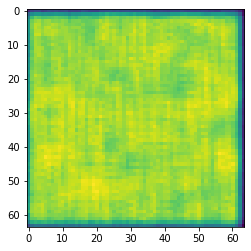

In [30]:
# Random Debug

In [22]:
z1[0, 0, :, :].cpu().detach().numpy().shape

(64, 64)

# Random Debug

In [ ]:
CA1 = population[a]
CA2 = population[b]

with torch.no_grad():
    CA1.initGrid(2)
    CA2.initGrid(1)

    K1 = 25
    K2 = 25

    for k in range(K1):
        CA1.forward()
    for k in range(K2):
        CA2.forward()

In [ ]:
im1 = CA1.psi.cpu().detach().numpy()[0, 0:3, :, :].transpose(1, 2, 0)
im2 = CA1.psi.cpu().detach().numpy()[1, 0:3, :, :].transpose(1, 2, 0)
plt.imshow(np.abs(im2-im1)/2)

In [ ]:
plt.imshow((CA2.psi.cpu().detach().numpy()[0, 0:3, :, :].transpose(1, 2, 0) + 1)/2)

In [ ]:
plt.imshow(embed.forward(CA1.psi).cpu().detach().numpy()[0, 0:3, :, :].transpose(1, 2, 0))

In [ ]:
np.shape(lzs)

In [ ]:
embed.forward(population[0].psi).mean(3).mean(2).cpu().detach().numpy().shape

In [ ]:
plt.plot(embed.forward(CA1.psi).mean(3).mean(2).cpu().detach().numpy().transpose())

In [ ]:
embed.forward(population[0].psi).cpu().detach().numpy().shape

In [ ]:
zs.shape

In [120]:
zs.shape